
# Millennial Friendly Neighborhoods in London 

## Introduction

In this project I will aim to identify millennial-friendly neighborhoods in London. This project is targeted towards young professionals looking for new homes in London, stakeholders that provide housing targeted at young professionals, or city planners that are looking to make neighborhoods more millennial friendly.

Finding a neighbourhood that is millennial-friendly can be hard. Especially, in big cities like London. There are many variables to consider such as crime rates, rental prices, availability of public transport, and nearby enterainment.

To determine which neighbourhoods are millennial friendly we will focus on neighborhoods with low crime rates, easy to access to nearby entertainment (such as pubs and parks), short commute times and affordable rent.

## Data
To identify millennial-friendly neighbourhoods we will need the following data:

* Number of crime incidents per postcode
* Ease of access to public transport
* Average rent for a 2 bedroom appartment
* The total number of pubs in each neighborhood
* The total number of parks in each neighborhood

We will extract the crime data from from the Metropolitan and London City [police](https://data.police.uk/data/ "Police Data") datasets.

We will extract the rental and public transport and postcode data from the [MyLondon](https://data.london.gov.uk/dataset/mylondon "London Data") datasets on the London Datastore.

The data will then be grouped by outer postcode in order to get the average rental price for per postcode and the average length of commute to Bank station in minutes.

A key requirement of this analysis is to use the Foursquare API, which will be used to source the data regarding pubs and parks. In order to use the Foursquare API we will need to add the coordinates of each postcode to the dataframe, this data can be sourced from [FreeMapTools](https://www.freemaptools.com/download-uk-postcode-lat-lng.htm "postcode coordinates"). 

With all the data sourced we will end up with a dataframe similar to the below:

| postcode  | crime  |  time_to_bank_mins |  ave_rent_2_bedroom | latitude| longitude | pubs | parks
|---|---|---|---|---|---|---|---|
|   BR1 |  43309 | 67.53  |   1102.29|   51.4110|  0.0219 | 12 | 8 |


## Methodology

This section shows the various steps taken to consolidate the different datasets, the data wrangling.

In [3]:
# import relevant libraries for data wrangling
import pandas as pd
import numpy as np
import os as os
import glob as glob

In [4]:
# import crime data
os.chdir('/Users/RW/Desktop/crime')
extension = 'csv'
all_filenames = [i for i in glob.glob('*.{}'.format(extension))]
ldn_crime = pd.concat([pd.read_csv(f) for f in all_filenames ])
ldn_crime.dropna(subset=['LSOA code'], inplace=True)
ldn_crime.head(2)

,Crime ID,Month,Reported by,Falls within,Longitude,Latitude,Location,LSOA code,LSOA name,Crime type,Last outcome category,Context
0,d59c0bcf3ba28eaedbf70002e5f491c4a2861f4747559d...,2019-05,Metropolitan Police Service,Metropolitan Police Service,-0.335092,50.837110,On or near Downlands Close,E01031344,Adur 006A,Other theft,Status update unavailable,NaN
1,d2d82438177979dd55b4e9996d52d5803a767ec540a4b2...,2019-05,Metropolitan Police Service,Metropolitan Police Service,0.870209,51.146748,On or near Elwick Road,E01024027,Ashford 005D,Robbery,Status update unavailable,NaN


In [5]:
# drop irrelevant columns from ldn_crime dataframe and groupby LSOA
ldn_crime.drop(['Crime ID', 'Month', 'Reported by', 'Falls within', 'Location', 'Context',
               'LSOA name', 'Crime type', 'Last outcome category', 'Latitude', 'Longitude' ], axis=1, inplace=True)

In [6]:
# get total number of crime incidents per LSOA
grpd = ldn_crime.groupby(['LSOA code']).size().to_frame('size')

In [7]:
# reset index and display dataframe
grpd =  grpd.reset_index()
grpd

,LSOA code,size
0,E01000001,359
1,E01000002,336
2,E01000003,68
3,E01000005,748
4,E01000006,110
...,...,...
6228,W01001867,1
6229,W01001870,3
6230,W01001913,1
6231,W01001938,1


In [8]:
# remove the'W01' values as these areas are located outside of London 
grpd = grpd[grpd['LSOA code'].str.startswith('E01')]
grpd.shape

(6194, 2)

In [9]:
# import output area data which will be required to merge the datasets later on
oa = pd.read_csv('/Users/RW/Desktop/data/bbox.csv')
oa.head(2)

,lsoa,oa,left,bottom,right,top,EASTING,NORTHING,Latitude,Longitude
0,E01000001,E00000001,-0.096516,51.519759,-0.094389,51.520663,532270,181870,51.520269,-0.0950
1,E01000001,E00000003,-0.097048,51.519329,-0.095787,51.520325,532150,181820,51.519848,-0.0967


In [10]:
# drop drop duplicates, irrelevant columns and rename 'lsoa' column
oa.drop(['left', 'bottom', 'right', 'top', 'EASTING', 'NORTHING', 'Latitude', 'Longitude'], axis=1, inplace=True)
oa.rename(columns = {'lsoa':'LSOA code'}, inplace=True)
oa = oa.drop_duplicates(subset=['LSOA code'])
oa.head(2)

,LSOA code,oa
0,E01000001,E00000001
4,E01000003,E00000010


In [11]:
# add 'oa' value to grpd dataframe
ldn_df = pd.merge(grpd, oa, how='left',left_on='LSOA code', right_on='LSOA code')
ldn_df.head(2)

,LSOA code,size,oa
0,E01000001,359,E00000001
1,E01000002,336,E00000016


In [12]:
# import rental data
rent = pd.read_csv('/Users/RW/Desktop/data/rent.csv')
rent.head(2)

,OA11CD,Ave_rent_1_bedroom,Ave_rent_2_bedroom,Ave_rent_3_bedroom,Ave_rent_4_bedroom
0,E00009198,772,958,1228,1544
1,E00008723,1138,1412,1810,2275


In [13]:
# drop irrelevant columns and merge with ldn_df
rent.drop(['Ave_rent_1_bedroom', 'Ave_rent_3_bedroom', 'Ave_rent_4_bedroom'], axis=1, inplace=True)
rent.rename(columns={'OA11CD':'oa', 'Ave_rent_2_bedroom':'ave_rent_2_bedroom'}, inplace=True)
ldn_df = pd.merge(ldn_df, rent, how='left',left_on='oa', right_on='oa')
ldn_df.head(2)

,LSOA code,size,oa,ave_rent_2_bedroom
0,E01000001,359,E00000001,4063.0
1,E01000002,336,E00000016,2429.0


In [14]:
# import public transport data
travel = pd.read_csv('/Users/RW/Desktop/data/travel_time.csv')
travel.head(2)

,OA11CD,driving_distance_miles,driving_time_mins,public_transport_time_mins,cycling_distance_miles,cycling_time_mins,walking_distance_miles,walking_time_mins
0,E00000001,0.86,6,16,0.83,6,0.80,16
1,E00000003,0.99,7,14,0.98,7,0.73,14


In [15]:
# drop irrelevant columns and merge with ldn_df
travel.drop(['driving_distance_miles', 'driving_distance_miles', 'driving_time_mins', 'cycling_distance_miles', 
            'cycling_time_mins', 'walking_distance_miles', 'walking_time_mins'], axis=1, inplace=True)
travel.rename(columns = {'OA11CD': 'oa','public_transport_time_mins':'time_to_bank_mins'}, inplace=True)
ldn_df = pd.merge(ldn_df, travel, how='left',left_on='oa', right_on='oa')
ldn_df.head(2)

,LSOA code,size,oa,ave_rent_2_bedroom,time_to_bank_mins
0,E01000001,359,E00000001,4063.0,16.0
1,E01000002,336,E00000016,2429.0,15.0


In [16]:
# import postcode dataset
postcode = pd.read_csv('/Users/RW/Desktop/data/postcode.csv')
postcode.head(2)

,OA11CD,PC_DIST
0,E00003110,BR1
1,E00003120,BR1


In [17]:
# rename columns and merge with ldn_df
postcode.rename(columns = {'OA11CD': 'oa','PC_DIST':'postcode'} ,inplace = True)
ldn_df = pd.merge(ldn_df, postcode, how='left',left_on='oa', right_on='oa')
ldn_df.head(2)

,LSOA code,size,oa,ave_rent_2_bedroom,time_to_bank_mins,postcode
0,E01000001,359,E00000001,4063.0,16.0,EC2Y
1,E01000002,336,E00000016,2429.0,15.0,EC2Y


In [18]:
# import postcode coordinates
coords = pd.read_csv('/Users/RW/Desktop/data/coords.csv')
coords.head(2)

,id,postcode,latitude,longitude
0,2,AB10,57.13514,-2.11731
1,3,AB11,57.13875,-2.09089


In [19]:
# drop irrelevant columns and merge with ldn_df
coords.drop(['id'], axis=1, inplace=True)
ldn_df = pd.merge(ldn_df, coords, how='left',left_on='postcode', right_on='postcode')
ldn_df.head(2)

,LSOA code,size,oa,ave_rent_2_bedroom,time_to_bank_mins,postcode,latitude,longitude
0,E01000001,359,E00000001,4063.0,16.0,EC2Y,51.52007,-0.09579
1,E01000002,336,E00000016,2429.0,15.0,EC2Y,51.52007,-0.09579


In [20]:
# check for missing coordinates
ldn_df[ldn_df['latitude']== 0.0]

,LSOA code,size,oa,ave_rent_2_bedroom,time_to_bank_mins,postcode,latitude,longitude
940,E01000958,422,E00004740,1323.0,34.0,N1C,0.0,0.0


In [21]:
# manually add missing coordinates to dataframe
ldn_df.loc[940, 'latitude'] = 51.5373
ldn_df.loc[940, 'longitude'] = -0.1249
ldn_df.head(945)

,LSOA code,size,oa,ave_rent_2_bedroom,time_to_bank_mins,postcode,latitude,longitude
0,E01000001,359,E00000001,4063.0,16.0,EC2Y,51.52007,-0.09579
1,E01000002,336,E00000016,2429.0,15.0,EC2Y,51.52007,-0.09579
2,E01000003,68,E00000010,1278.0,17.0,EC1M,51.52106,-0.10152
3,E01000005,748,E00000029,1344.0,17.0,E1,51.51766,-0.05841
4,E01000006,110,E00000049,1223.0,44.0,IG11,51.53573,0.09378
...,...,...,...,...,...,...,...,...
940,E01000958,422,E00004740,1323.0,34.0,N1C,51.53730,-0.12490
941,E01000959,177,E00004743,1345.0,31.0,NW1,51.53252,-0.14286
942,E01000960,87,E00004786,1504.0,32.0,NW3,51.55184,-0.17093
943,E01000961,154,E00004777,881.0,33.0,NW8,51.53117,-0.17175


In [22]:
# drop missig values
ldn_df = ldn_df.dropna()

In [23]:
# drop irrelevant columns
ldn_df.drop(['LSOA code', 'oa'], axis=1, inplace=True)

In [24]:
# group by postcode to get the total crime per postcode and the average rent/commute/coordinates per postcode
ldn_mil = ldn_df.groupby('postcode').agg({'size':'sum', 'ave_rent_2_bedroom':'mean','time_to_bank_mins':'mean',
                                      'latitude':'mean', 'longitude':'mean' })
ldn_mil = ldn_mil.round({'ave_rent_2_bedroom':2,'time_to_bank_mins':2}).reset_index()
ldn_mil

,postcode,size,ave_rent_2_bedroom,time_to_bank_mins,latitude,longitude
0,BR1,7677,1222.42,68.72,51.41107,0.02192
1,BR2,3490,1360.40,71.60,51.38858,0.02237
2,BR3,4483,1428.48,62.68,51.40297,-0.03020
3,BR4,1047,1427.92,86.75,51.37559,-0.00695
4,BR5,4848,1030.80,68.67,51.38983,0.10436
...,...,...,...,...,...,...
241,WC1N,378,1645.00,23.50,51.52136,-0.12025
242,WC1X,2452,1742.17,22.17,51.52489,-0.11578
243,WC2B,2079,3799.00,19.00,51.51510,-0.12195
244,WC2H,12803,2797.00,22.00,51.51339,-0.12778


In [25]:
# some final cleanig, rename 'size' column
ldn_mil.rename(columns={'size':'crime_incidents'}, inplace=True)
ldn_mil.head(2)

,postcode,crime_incidents,ave_rent_2_bedroom,time_to_bank_mins,latitude,longitude
0,BR1,7677,1222.42,68.72,51.41107,0.02192
1,BR2,3490,1360.40,71.60,51.38858,0.02237


Now using the Foursquare API we will get the total number of pubs and parks per postcode

In [26]:
# create empty columns for the pubs and parks data
ldn_mil['parks'] = ''
ldn_mil['pubs'] = ''
ldn_mil.head()

,postcode,crime_incidents,ave_rent_2_bedroom,time_to_bank_mins,latitude,longitude,parks,pubs
0,BR1,7677,1222.42,68.72,51.41107,0.02192,,
1,BR2,3490,1360.40,71.60,51.38858,0.02237,,
2,BR3,4483,1428.48,62.68,51.40297,-0.03020,,
3,BR4,1047,1427.92,86.75,51.37559,-0.00695,,
4,BR5,4848,1030.80,68.67,51.38983,0.10436,,


In [27]:
client_id = 'E3RBE2LGU3DIOXIG5SYXTMUMGWUC5D1RVXQBJIEUOF0KR3QP' 
client_secret = 'D0W40TGFX01S4YR4A3VA4E0UL43KW2HOJOPHDS4AW5ELT2AI'
version = '20180604'
print('Your credentails:')
print('client_id: ' + client_id)
print('client_secret:' + client_secret)

Your credentails:
client_id: E3RBE2LGU3DIOXIG5SYXTMUMGWUC5D1RVXQBJIEUOF0KR3QP
client_secret:D0W40TGFX01S4YR4A3VA4E0UL43KW2HOJOPHDS4AW5ELT2AI


In [28]:
# define a function to count the number of pubs and parks per postcode
import requests

limit = 50
radius = 1000
def get_number_of_venues(ID, category):
    for i in range(len(ldn_mil)):
        p_lat = ldn_mil.iloc[i,4]
        p_lon = ldn_mil.iloc[i,5]
        url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&categoryId={}&radius={}&limit={}'.format(client_id,client_secret,p_lat,p_lon,version,ID,radius,limit) 
        test_results = requests.get(url).json()
        test_venue = test_results['response']['venues']
        count = np.shape(test_venue)
        ldn_mil.loc[i, category] = count[0]

In [29]:
# get the total number of pubs and parks and add them to the dataframe
get_number_of_venues('4bf58dd8d48988d163941735', 'parks')
get_number_of_venues('4bf58dd8d48988d11b941735', 'pubs')
ldn_mil

,postcode,crime_incidents,ave_rent_2_bedroom,time_to_bank_mins,latitude,longitude,parks,pubs
0,BR1,7677,1222.42,68.72,51.41107,0.02192,7,15
1,BR2,3490,1360.40,71.60,51.38858,0.02237,2,5
2,BR3,4483,1428.48,62.68,51.40297,-0.03020,8,4
3,BR4,1047,1427.92,86.75,51.37559,-0.00695,6,6
4,BR5,4848,1030.80,68.67,51.38983,0.10436,2,2
...,...,...,...,...,...,...,...,...
241,WC1N,378,1645.00,23.50,51.52136,-0.12025,26,50
242,WC1X,2452,1742.17,22.17,51.52489,-0.11578,30,50
243,WC2B,2079,3799.00,19.00,51.51510,-0.12195,30,50
244,WC2H,12803,2797.00,22.00,51.51339,-0.12778,26,50


In [30]:
# check the type of data in each column
ldn_mil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246 entries, 0 to 245
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   postcode            246 non-null    object 
 1   crime_incidents     246 non-null    int64  
 2   ave_rent_2_bedroom  246 non-null    float64
 3   time_to_bank_mins   246 non-null    float64
 4   latitude            246 non-null    float64
 5   longitude           246 non-null    float64
 6   parks               246 non-null    object 
 7   pubs                246 non-null    object 
dtypes: float64(4), int64(1), object(3)
memory usage: 15.5+ KB


In [31]:
# change parks and pubs to typt interger
ldn_mil['parks'] = ldn_mil['parks'].astype('int')
ldn_mil['pubs'] = ldn_mil['pubs'].astype('int')
ldn_mil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246 entries, 0 to 245
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   postcode            246 non-null    object 
 1   crime_incidents     246 non-null    int64  
 2   ave_rent_2_bedroom  246 non-null    float64
 3   time_to_bank_mins   246 non-null    float64
 4   latitude            246 non-null    float64
 5   longitude           246 non-null    float64
 6   parks               246 non-null    int64  
 7   pubs                246 non-null    int64  
dtypes: float64(4), int64(3), object(1)
memory usage: 15.5+ KB


Brilliant, we now have our completed dataset to work with. The next section will take a more in depth look at the results.

## Results

Let's take a look at the results and try visualise them.

In [32]:
# look at the distribution of the data
ldn_mil.describe()

,crime_incidents,ave_rent_2_bedroom,time_to_bank_mins,latitude,longitude,parks,pubs
count,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000
mean,4479.052846,1877.667195,50.289187,51.507070,-0.114946,8.800813,18.817073
std,3389.030061,1945.403408,16.975429,0.073655,0.158058,8.689482,16.981715
min,51.000000,473.330000,8.000000,51.293620,-0.490190,0.000000,0.000000
25%,2331.750000,1116.880000,37.825000,51.460483,-0.202522,3.000000,5.000000
50%,3554.500000,1422.215000,51.400000,51.512520,-0.119730,6.000000,11.000000
75%,6021.750000,1985.345000,62.210000,51.558405,-0.018107,11.000000,29.000000
max,21872.000000,22558.000000,96.250000,51.697990,0.264960,37.000000,50.000000


A quick analysis of the different categories: 

* 50% of crime is between 2,331 and 6,021 incidents with the average being 4479. 
* 50% of 2 bedroom rent is between £1,116 and £1,985 per month with the average being £1,877.
* 50% of the commute time to Bank is between 37 and 62 minutes with the average being 50 minutes.

As for the pubs and parks, the radius was set 1km so there may be an overlap between the different postcodes. However based on the above distribution:
* 50% of parks is between 3 and 11 parks per postcode with the average being 8.
* 50% of pubs is between 5 and 28 pubs per postcode with the average being 18.


Let's start by visualising the crime data.

Text(0, 0.5, '# of Crime Incidents')

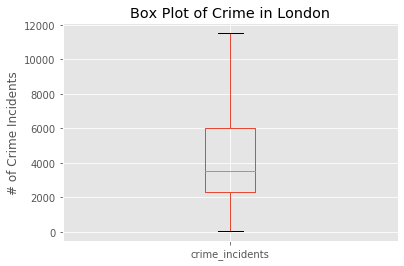

In [33]:
# create a box plot to visualise the crime data
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use(['ggplot'])

ldn_mil['crime_incidents'].plot(kind = 'box', showfliers=False)
plt.title('Box Plot of Crime in London')
plt.ylabel('# of Crime Incidents')

Now let's visualise this data on a map. We will assume that anything within the interquartile range is the average amount of crime one should expect in London. Anything below is low crime and can be considered safe, anything above is high crime and should be deemed unsafe.

In [34]:
# obtain latitude and longitude for London
from geopy.geocoders import Nominatim
import folium

geolocator = Nominatim(user_agent='UK_Explorer')
location1 = geolocator.geocode('London, UK')
lon_lat = location1.latitude
lon_lng = location1.longitude
# create map with crime data
london_crime_map = folium.Map(location = [lon_lat, lon_lng], zoom_start = 10)
for lat, lng, post, crime in zip(ldn_mil['latitude'], 
                                 ldn_mil['longitude'], 
                                 ldn_mil['postcode'], 
                                 ldn_mil['crime_incidents']):
    label = '{}: Crime: {} incidents'.format(post, crime)
    label = folium.Popup(label, parse_html = True)
    if int(crime) < 2331:
        color="green" 
    elif int(crime) >  6021:
        color = "red"
    else: 
        color="yellow"
    folium.CircleMarker([lat, lng], 
                        radius = 4, 
                        popup = label, 
                        color = color,
                        fill = True, 
                        fill_opacity = 0.6, 
                        parse_html = False).add_to(london_crime_map)
london_crime_map

We can see that as you move towards the centre of London the level of crime tends to increase. Now let's have a look at the rental data and visualise it in the same way.

Text(0, 0.5, 'Average Rent in £')

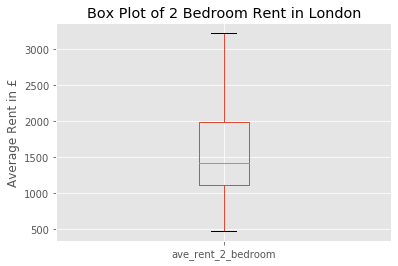

In [35]:
# create a box plot to visualise the rental data
ldn_mil['ave_rent_2_bedroom'].plot(kind = 'box', showfliers=False)
plt.title('Box Plot of 2 Bedroom Rent in London')
plt.ylabel('Average Rent in £')

Now let's visualise this data on a map. We will assume that anything within the interquartile range is the average rent one should expect to pay renting a 2 bedroom appartment in London. Anything below can be considered relatively cheap and anything above can be consdered relatively expensive.

In [56]:
# create map with rental data
london_rental_map = folium.Map(location = [lon_lat, lon_lng], zoom_start = 10)
for lat, lng, post, rent in zip(ldn_mil['latitude'], 
                                 ldn_mil['longitude'], 
                                 ldn_mil['postcode'], 
                                 ldn_mil['ave_rent_2_bedroom']):
    label = '{}: Rent: {}'.format(post, rent)
    label = folium.Popup(label, parse_html = True)
    if int(rent) < 1116:
        color="green" 
    elif int(rent) > 1985:
        color = "red"
    else: 
        color="yellow"
    folium.CircleMarker([lat, lng], 
                        radius = 4, 
                        popup = label, 
                        color = color,
                        fill = True, 
                        fill_opacity = 0.6, 
                        parse_html = False).add_to(london_rental_map)
london_rental_map

We can clearly see that the rent in west London tends to be higher than the rent in east London. Now let's have a look at the commute time and visualise it in the same way.

Text(0, 0.5, 'Average Commute Time in Min')

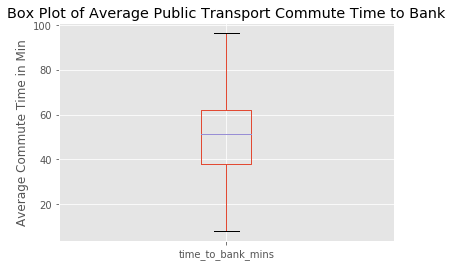

In [37]:
# create a box plot to visualise the commute data
ldn_mil['time_to_bank_mins'].plot(kind = 'box', showfliers=False)
plt.title('Box Plot of Average Public Transport Commute Time to Bank')
plt.ylabel('Average Commute Time in Min')

Now let's visualise this data on a map. We will assume that anything within the interquartile range is the average commute time one should expect to spend on public transport when commuting to Bank station. Anything below can be considered a short commute and anything above can be consdered a long commute.

In [38]:
# create map with commute data
london_commute_map = folium.Map(location = [lon_lat, lon_lng], zoom_start = 10)
for lat, lng, post, time in zip(ldn_mil['latitude'], 
                                 ldn_mil['longitude'], 
                                 ldn_mil['postcode'], 
                                 ldn_mil['time_to_bank_mins']):
    label = '{}: Time: {}min'.format(post, time)
    label = folium.Popup(label, parse_html = True)
    if int(time) < 37:
        color="green" 
    elif int(time) > 62:
        color = "red"
    else: 
        color="yellow"
    folium.CircleMarker([lat, lng], 
                        radius = 4, 
                        popup = label, 
                        color = color,
                        fill = True, 
                        fill_opacity = 0.6, 
                        parse_html = False).add_to(london_commute_map)
london_commute_map

This was pretty obvious, the further outside central London you are the longer it will take you to get to the centre. Now let's have a look at parks data.

In [51]:
# create map with parks data
london_parks_map = folium.Map(location = [lon_lat, lon_lng], zoom_start = 10)
for lat, lng, post, rent in zip(ldn_mil['latitude'], 
                                 ldn_mil['longitude'], 
                                 ldn_mil['postcode'], 
                                 ldn_mil['parks']):
    label = '{}: Parks: {}'.format(post, rent)
    label = folium.Popup(label, parse_html = True)
    if int(rent) < 3:
        color="red" 
    elif int(rent) > 11:
        color = "green"
    else: 
        color="yellow"
    folium.CircleMarker([lat, lng], 
                        radius = 4, 
                        popup = label, 
                        color = color,
                        fill = True, 
                        fill_opacity = 0.6, 
                        parse_html = False).add_to(london_parks_map)
london_parks_map

It is clear that there is a higher concentration of parks in central London. However, zooming in on the map we see that most of these tend to be quite small whereas the parks further out are much larger. Now let's look at pubs data.

In [55]:
# create map with pub data
london_pub_map = folium.Map(location = [lon_lat, lon_lng], zoom_start = 10)
for lat, lng, post, rent in zip(ldn_mil['latitude'], 
                                 ldn_mil['longitude'], 
                                 ldn_mil['postcode'], 
                                 ldn_mil['pubs']):
    label = '{}: Pubs: {}'.format(post, pubs)
    label = folium.Popup(label, parse_html = True)
    if int(rent) < 5:
        color="red" 
    elif int(rent) > 28:
        color = "green"
    else: 
        color="yellow"
    folium.CircleMarker([lat, lng], 
                        radius = 4, 
                        popup = label, 
                        color = color,
                        fill = True, 
                        fill_opacity = 0.6, 
                        parse_html = False).add_to(london_pub_map)
london_pub_map

Clearly there is a higher concentration of pubs around central London, which is expected. Now let's look at clustering the data.

In [40]:
# select a subset of the data that only includes the crime, rent, commute, parks and pubs data
ldn_cluster = ldn_mil[['crime_incidents','ave_rent_2_bedroom','time_to_bank_mins', 'parks','pubs']]
ldn_cluster

,crime_incidents,ave_rent_2_bedroom,time_to_bank_mins,parks,pubs
0,7677,1222.42,68.72,7,15
1,3490,1360.40,71.60,2,5
2,4483,1428.48,62.68,8,4
3,1047,1427.92,86.75,6,6
4,4848,1030.80,68.67,2,2
...,...,...,...,...,...
241,378,1645.00,23.50,26,50
242,2452,1742.17,22.17,30,50
243,2079,3799.00,19.00,30,50
244,12803,2797.00,22.00,26,50


In order to identify the optimal number of k clusters we will need to first normalise the data.

In [41]:
# import preprocessing from sklearn
from sklearn import preprocessing

In [42]:
# normalise the data 
x = ldn_mil[['crime_incidents', 'ave_rent_2_bedroom', 'time_to_bank_mins', 'parks', 'pubs']].values.astype(float)
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_normalized = pd.DataFrame(x_scaled)
df_normalized

,0,1,2,3,4
0,0.349480,0.033919,0.688045,0.189189,0.30
1,0.157600,0.040167,0.720680,0.054054,0.10
2,0.203107,0.043249,0.619603,0.216216,0.08
3,0.045644,0.043224,0.892351,0.162162,0.12
4,0.219834,0.025242,0.687479,0.054054,0.04
...,...,...,...,...,...
241,0.014986,0.053054,0.175637,0.702703,1.00
242,0.110032,0.057453,0.160567,0.810811,1.00
243,0.092938,0.150587,0.124646,0.810811,1.00
244,0.584391,0.105216,0.158640,0.702703,1.00


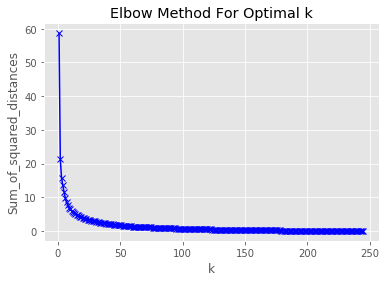

In [43]:
# check optimal number of clusters
from sklearn.cluster import KMeans

elbow = []
for k in range(1,len(df_normalized)):
    km = KMeans(n_clusters = k, random_state = 0).fit(df_normalized)
    elbow.append(km.inertia_)
    K = range(1,len(df_normalized))
plt.plot(K,  elbow,'bx-')
plt.xlabel('k')  
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

It's impossible to see the elbow point. Although can see it occurs close to zero, so we will replot with just a subset of the data.

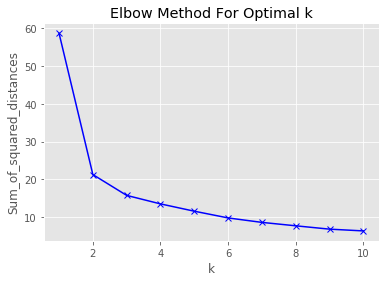

In [44]:
elbow2 = elbow[0:10]
K = range(1,11)
#plt.figure(figsize =(20,10))
plt.plot(K,  elbow2,'bx-')
plt.xlabel('k')  
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

We can see the optimal vaue is k = 3.

In [45]:
# create clusters and add to dataframe
cluster_num = 3
ldn_kmeans = KMeans(n_clusters = cluster_num, random_state = 0).fit(ldn_cluster)
ldn_mil.insert(0,'Cluster_Labels', ldn_kmeans.labels_)
ldn_mil.head()

,Cluster_Labels,postcode,crime_incidents,ave_rent_2_bedroom,time_to_bank_mins,latitude,longitude,parks,pubs
0,1,BR1,7677,1222.42,68.72,51.41107,0.02192,7,15
1,2,BR2,3490,1360.40,71.60,51.38858,0.02237,2,5
2,1,BR3,4483,1428.48,62.68,51.40297,-0.03020,8,4
3,2,BR4,1047,1427.92,86.75,51.37559,-0.00695,6,6
4,1,BR5,4848,1030.80,68.67,51.38983,0.10436,2,2


In [46]:
# visualise clusters on map
cluster_map = folium.Map(location = [lon_lat, lon_lng], zoom_start = 10)
for lat, lng, post, crime, parks, pubs, rent, commute, cluster in zip(ldn_mil['latitude'],
                                          ldn_mil['longitude'], 
                                          ldn_mil['postcode'], 
                                          ldn_mil['crime_incidents'],
                                          ldn_mil['parks'],
                                          ldn_mil['pubs'],
                                          ldn_mil['ave_rent_2_bedroom'],
                                          ldn_mil['time_to_bank_mins'],
                                          ldn_mil['Cluster_Labels']):
    label = 'Clust: {} PC: {} Crime: {} Park: {} Pub: {} Rent: {} Commute: {}' .format(cluster,post, crime, parks, pubs, rent, commute)
    label = folium.Popup(label, parse_html = True)
    if cluster == 0:
        color="red" 
    elif cluster == 1:
        color = "yellow"
    elif cluster == 2:
        color = "green"
    folium.CircleMarker([lat, lng], 
                        radius = 4, 
                        popup = label, 
                        color = color,
                        fill = True, 
                        fill_opacity = 0.6, 
                        parse_html = False).add_to(cluster_map)
cluster_map

The red dots have a significantly higher amount of crime and should be probably be avoided when looking for a millennial-friendly neighbourhood.

## Discussion

Let's have a look at the results and what they mean.

([<matplotlib.axis.XTick at 0x7fed51c65850>,
 <a list of 3 Text xticklabel objects>)

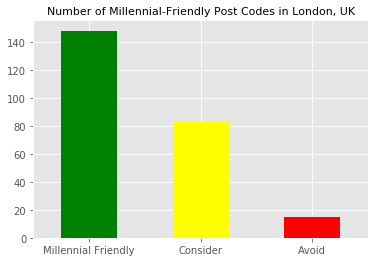

In [47]:
# bar char to show the number of millennial-friendly post codes in London.
ldn_mil['Cluster_Labels'].value_counts().plot(kind = 'bar', color =['green', 'yellow', 'red'])
plt.title('Number of Millennial-Friendly Post Codes in London, UK', fontsize = 11)
plt.xticks(np.arange(3), ('Millennial Friendly', 'Consider', 'Avoid'), rotation = 'horizontal')

We can see there is a large number of millennial friendly post codes in London, which is good news for millennials moving to London.

In [48]:
# the top 10 safest London post codes
safe = ldn_mil.sort_values(by = 'crime_incidents', axis=0, ascending=True)                                            
safe.reset_index(drop=True, inplace=True)
safe.head(10)

,Cluster_Labels,postcode,crime_incidents,ave_rent_2_bedroom,time_to_bank_mins,latitude,longitude,parks,pubs
0,2,IG9,51,1224.00,57.00,51.62391,0.04004,1,3
1,2,CR9,63,1730.00,87.00,51.37223,-0.07463,5,5
2,2,RM4,254,1554.00,92.50,51.63255,0.16038,0,0
3,2,WC1N,378,1645.00,23.50,51.52136,-0.12025,26,50
4,2,EC1Y,416,1887.00,19.00,51.52272,-0.09280,37,49
5,2,N1C,422,1323.00,34.00,51.53730,-0.12490,20,48
6,2,EN8,528,864.50,66.50,51.69799,-0.03189,5,9
7,2,DA18,534,473.33,57.67,51.49165,0.14363,0,2
8,2,W1G,591,3813.00,32.00,51.51818,-0.14633,29,50
9,2,SW1X,594,12716.50,34.50,51.49760,-0.15293,13,50


These are the top 10 safest post codes in London. The central postcodes with affordable rent - such as EC1Y, N1C and WC1N offer a short commute, a high degree of safety and easy access to a large number of pubs and parks. These would be a good starting point for millennials when searching for a property rent in London.

In [49]:
# the top 10 most dangerous London post codes
danger = ldn_mil.sort_values(by = 'crime_incidents', axis=0, ascending=False)                                            
danger.reset_index(drop=True, inplace=True)
danger.head(10)

,Cluster_Labels,postcode,crime_incidents,ave_rent_2_bedroom,time_to_bank_mins,latitude,longitude,parks,pubs
0,0,SE1,21872,2025.50,25.18,51.49838,-0.08949,31,50
1,0,CR0,21399,987.48,71.90,51.37223,-0.07463,5,5
2,0,N1,18133,2241.00,27.62,51.53717,-0.09652,29,50
3,0,E1,15949,1512.24,25.03,51.51766,-0.05841,27,50
4,0,NW1,14840,1977.38,31.71,51.53252,-0.14286,30,50
5,0,NW10,13172,1763.69,51.22,51.53951,-0.24641,6,9
6,0,WC2H,12803,2797.00,22.00,51.51339,-0.12778,26,50
7,0,E17,12768,1198.60,44.42,51.58623,-0.01796,3,20
8,0,W2,12118,3728.14,33.21,51.51508,-0.17816,12,44
9,0,E15,12038,1212.28,35.88,51.53911,0.00307,6,22


The majority of these postcodes tend to be centrally located, with a few notable outliers such as CR0, NW10, E17 and E15.

In [50]:
# top 10 post codes in terms of activities
ldn_mil['total_pubs_parks'] = ldn_mil['parks'] + ldn_mil['pubs']
act = ldn_mil.sort_values(by = 'total_pubs_parks', axis=0, ascending=False)
act.reset_index(drop=True, inplace=True)
act.head(10)

,Cluster_Labels,postcode,crime_incidents,ave_rent_2_bedroom,time_to_bank_mins,latitude,longitude,parks,pubs,total_pubs_parks
0,2,EC1Y,416,1887.00,19.00,51.52272,-0.09280,37,49,86
1,2,EC1M,1512,2803.00,16.67,51.52106,-0.10152,35,50,85
2,2,EC1R,963,1931.00,21.25,51.52475,-0.10713,34,50,84
3,2,EC1V,1563,2030.33,21.50,51.52549,-0.09701,35,49,84
4,2,WC1H,3450,1696.14,24.71,51.52415,-0.12590,32,50,82
5,0,SE1,21872,2025.50,25.18,51.49838,-0.08949,31,50,81
6,2,W1T,2416,1869.00,25.00,51.51980,-0.13473,31,50,81
7,0,W1W,11473,3053.67,29.00,51.51897,-0.13909,30,50,80
8,2,WC2B,2079,3799.00,19.00,51.51510,-0.12195,30,50,80
9,2,WC1X,2452,1742.17,22.17,51.52489,-0.11578,30,50,80


EC1Y appears again on this list (in addition to the top 10 safest post codes list). Eyeballing the rent, it also looks affordable compared to the other post codes on the list. Based on the above data, it is clear that EC1Y is the best post code in London for millennials to live.

## Conclusion

After evaluating post codes in London in terms of average rent, crime, commute time, and the accessibility of pubs and parks in the surrounding area we were able to identify a number of millennial-friendly neighbourhoods.

The results suggest there are numerous millennial-friendly neighborhoods to choose from. There are more than 140 millennial-friendly post codes located all across London. So millennials would not have a problem finding the right post code based on their own preferences, needs and budget.

A few points to note for further improvement:
* Not all post codes are of equal size which may have skewed the results and caused the crime rate to look superfically high or low, further analysis could be done by standardising crime data based on population.
* A 1km radius was used to define the boundaries of the post codes assigned latitudes and longitudes. This could cause some unwanted overlapping of post code zones while searching venues. This would also allow for chlorpleth maps to be made.
* More millennial-friendly activities could be added to the dataset (i.e. theatres, gyms, basketball courts, etc.)